# Incrustaciones con BETO

La incrustación (*embedding*) es el proceso por el que obtenemos números a partir de palabras. En este caso, realizaremos ese proceso con [BETO](https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased), la versión de BERT en español.

## 1. Importación de librerías y revisión del *dataframe*

In [40]:
import pandas as pd
import numpy as np
import re #para identificar patrones en textos
from matplotlib import pyplot as plt
from langdetect import detect #para detectar idiomas
from deep_translator import GoogleTranslator #para traducir texto
import seaborn as sns
import os #para manipular archivos del sistema operativo

Reviso las columnas que tengo en mi dataframe.

In [2]:
base=pd.read_csv('rawdata/clases/habitaclia5467_ejercicio2.csv')
print(base.columns.tolist())

['Unnamed: 0', 'OBJECTID', 'codigo_inmueble1', 'Title', 'Type_build', 'Type_opera', 'Link', 'Location', 'Lat_X', 'Lon_Y', 'Climatic_Z', 'Nom_Mun', 'precio_eur', 'superficie', 'superficie2', 'Unit_price', 'Ln_total_pr', 'Ln_unit_pr', 'numero_habitaciones', 'numero_bano', 'ratio_bano_hab', 'numero_aseo', 'ascensor', 'interac_planta', 'numero_de_piso', 'anyo_constr_ponderad', 'antig_ponderad', 'Inverse_Age', 'Year_Before_1981', 'Year_1982_2006', 'Year_After_2007', 'superficie_terraza_m2', 'grand_terr_20m2', 'superficie_jardin_m2', 'superficie_salon', 'bool_despacho', 'bool_buhardilla', 'bool_trastero', 'bool_lavadero', 'bool_piscina_comunitaria', 'bool_jardin_comunitario', 'bool_amueblado', 'bool_ascensor', 'descripcion', 'bool_aire_acondicionado', 'bool_calefaccion', 'bool_chimenea', 'texto_destacado', 'Description', 'calificacion_consumo_letra', 'calificacion_consumo_valor', 'calificacion_emision_letra', 'calificacion_emision_valor', 'Dum_EPC', 'EPC_A_emision', 'EPC_B_emision', 'EPC_C_e

Con `Ctrl+F` puedo ver que hay dos que podrían tener la descripción de los anuncios. Las reviso.

In [3]:
base[['Description','descripcion']].head()

,Description,descripcion
0,"Piso reformado de 4 habitaciones, salón comedo...",NaN
1,"BENET MATEU, PIS D´ORIGEN AMB MOLT BONA DISTRI...",NaN
2,Apartamento pero con acceso independiente desd...,conservada
3,"[A2977]PISAZO, EL MEJOR DE LA ZONA.FENOMENAL P...",reformada
4,[A3001]VIVIENDA EN LA CALLE GARROFER DE SANT I...,reformada


In [8]:
len(base)

5467

## 2. Limpieza de `Description`

Paso a limpiar el texto. Defino una serie de funciones.

In [4]:
def treat_euro(text):
    text = re.sub(r'(euro[^s])|(euros)|(€)', ' euros', text)
    return text

def treat_m2(text):
    text = re.sub(r'(m2)|(m²)', ' m²', text)
    return text

def filter_ibans(text):
    pattern = r'ES\d{2}[ ]\d{4}[ ]\d{4}[ ]\d{4}[ ]\d{4}[ ]\d{2}|ES\d{20}|ES[ ]\d{2}[ ]\d{3}[ ]\d{3}[ ]\d{3}[ ]\d{5}'
    text = re.sub(pattern, '', text)
    return text

def remove_space_between_numbers(text):
    text = re.sub(r'(\d)\s+(\d)', r'\1\2', text)
    return text

def filter_emails(text):
    pattern = r'(?:(?!.*?[.]{2})[a-zA-Z0-9](?:[a-zA-Z0-9.+!%-]{1,64}|)|\"[a-zA-Z0-9.+!% -]{1,64}\")@[a-zA-Z0-9][a-zA-Z0-9.-]+(.[a-z]{2,}|.[0-9]{1,})'
    text = re.sub(pattern, '', text)
    return text

def filter_ref(text):
    pattern = r'(\(*)(ref|REF)(\.|[ ])\d+(\)*)'
    text = re.sub(pattern, '', text)
    return text

def filter_websites(text):
    pattern = r'(http\:\/\/|https\:\/\/)?([a-z0-9][a-z0-9\-]*\.)+[a-z][a-z\-]*'
    text = re.sub(pattern, '', text)
    return text

def filter_phone_numbers(text):
    pattern = r'(?:(?:\+|00)33[\s.-]{0,3}(?:\(0\)[\s.-]{0,3})?|0)[1-9](?:(?:[\s.-]?\d{2}){4}|\d{2}(?:[\s.-]?\d{3}){2})|(\d{2}[ ]\d{2}[ ]\d{3}[ ]\d{3})'
    text = re.sub(pattern, '', text)
    return text

def remove_large_numbers(text):
    pattern = r'\b\d{4,}\b'
    text = re.sub(pattern, '', text)
    return text

def remove_text_in_brackets(text):
    pattern = r'\[[^\]]*\]|\{[^}]*\}'
    text = re.sub(pattern, '', text)
    return text

Ahora agrupo todas esas funciones y las aplico a `base` para crear una nueva columna.

In [5]:
def clean_text(text):
    if isinstance(text, str):  # Verifica si text es una cadena de texto
        text = text.replace(u'\xa0', u' ')
        text = treat_m2(text)
        text = treat_euro(text)
        text = filter_phone_numbers(text)
        text = filter_emails(text)
        text = filter_ibans(text)
        text = filter_ref(text)
        text = filter_websites(text)
        text = remove_space_between_numbers(text)
        text = remove_large_numbers(text)
        text = remove_text_in_brackets(text)
    return text

base['cl_descrip'] = base.Description.apply(clean_text)
base['cl_descrip'].head()

0    Piso reformado de 4 habitaciones, salón comedo...
1    BENET MATEU, PIS D´ORIGEN AMB MOLT BONA DISTRI...
2    Apartamento pero con acceso independiente desd...
3    PISAZO, EL MEJOR DE LA ZONA.FENOMENAL PISO SIN...
4    VIVIENDA EN LA CALLE GARROFER DE SANT IDELFONS...
Name: cl_descrip, dtype: object

Tenemos un problema más: **¡Hay texto en catalán!** Y probablemente en algún otro idioma, dado que algunos anuncios los ponen en distintos idiomas a la vez.

## 3. Corte de la descripción y traducción al español

Debido al tamaño de nuestro dataframe, es probable que convenga cortar la cantidad de palabras por celda. Primero, veamos la extensión de cada anuncio.

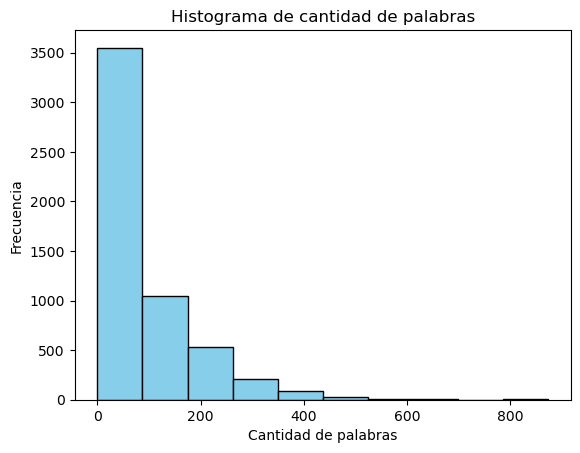

In [30]:
# Dividir cada elemento de la columna 'Description' en palabras y contar la cantidad de palabras
base['cantidad_palabras'] = base['cl_descrip'].apply(lambda x: len(x.split()))

# Crear un histograma de la cantidad de palabras
plt.hist(base['cantidad_palabras'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Cantidad de palabras')
plt.ylabel('Frecuencia')
plt.title('Histograma de cantidad de palabras')
plt.show()

Podemos exportar el archivo para ver qué características tienen aquellos anuncios más largos.

In [ ]:
#base[['cl_descrip','cantidad_palabras']].to_excel('rawdata/clases/extension_borrar_luego.xlsx')

Lo que veo es que aquellos que están por arriba de 300 usualmente tienen texto repetido, sólo que en distintos idiomas. Por tanto, pongo ese límite para mi dataframe. Ustedes, si lo consideran necesario, pueden cambiarlo.

Empiezo creando una columna que me indique el idioma en el que está cada fila con la función `detect` de `langdetect`.

In [11]:
# Función para detectar el idioma de un texto
def detect_language(text):
    try:
        return detect(text)
    except:
        return None

# Agrega una nueva columna 'Language' con el idioma detectado para cada descripción
base['Language'] = base['cl_descrip'].apply(detect_language)

In [33]:
base['Language'].head()

0    es
1    de
2    es
3    de
4    en
Name: Language, dtype: object

Los resultados no parecen ser tan buenos, pues reconoce el catalán como alemán, y en algunos casos, el mismo español como alemán.
Sin embargo, esto no debería ser un gran problema: si a continuación le pido que todas aquellas filas con un idioma distinto al español (`!= 'es'`) sean traducidas a ese idioma, aquellas que ya estén en español no sufrirán mayores cambios.

In [32]:
#En caso haya alguna celda en blanco, la relleno con un espacio en blanco
base['cl_descrip'] = base['cl_descrip'].fillna('')

# Función para cortar el texto a un máximo de 300 palabras
def truncate_text(text):
    words = text.split()[:300]
    truncated_text = ' '.join(words)
    return truncated_text

# Aplico la función para truncar el texto en la columna 'cl_descrip'
base['cl_descrip'] = base['cl_descrip'].apply(truncate_text)

# Filtro las filas que tienen 'Language' algo distinto al español ('es')
no_esp_descriptions = base[base['Language'] != 'es']['cl_descrip']

# Traduzco las descripciones al español
translated_descriptions = []
for description in no_esp_descriptions:
    translated_description = GoogleTranslator(source='auto', target='es').translate(description)
    translated_descriptions.append(translated_description)

# Reemplazo las descripciones traducidas en el DataFrame original
base.loc[base['Language'] != 'es', 'cl_descrip'] = translated_descriptions

base['cl_descrip'].head()

0    Piso reformado de 4 habitaciones, salón comedo...
1    BENET MATEU, PISO DE ORIGEN CON MUY BUENA DIST...
2    Apartamento pero con acceso independiente desd...
3    PISAZO, EL MEJOR DE LA ZONA.FENOMENAL PISO SIN...
4    VIVIENDA EN LA CALLE GARROFER DE SANT IDELFONS...
Name: cl_descrip, dtype: object

In [35]:
base['cl_descrip'].tail()

5462    Piso En Mollet Del Vallès!Ubicado a 600m de la...
5463    La Casa Agency presenta en Exclusividad, esta ...
5464    Mis Finques promociona esta planta baja con pa...
5465    PISO CON TERRAZAPiso con TERRAZA DE 40M2. La v...
5466    Precioso piso en una finca joven de tan solo 1...
Name: cl_descrip, dtype: object

Ya tenemos listo nuestro dataframe.

## 4. Incrustación 

La columna que había obtenido se llama `cl_descrip`. Así que sobre ella trabajo. 

**Cuidado**: la siguiente celda de código puede tomar entre 10-15 minutos para ejecutarse.

In [37]:
import torch
from transformers import BertTokenizer, BertModel

# Cargar el tokenizador y el modelo BERT preentrenado en español
tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
model = BertModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

# Definir una función para generar las incrustaciones BERT
def generate_bert_embeddings(description):
    if not isinstance(description, str) or not description.strip():
        return torch.zeros(1, 768)  # Devolver un tensor de ceros para descripciones no válidas
    else:
        # Tokenizar la descripción
        tokens = tokenizer(description, return_tensors='pt', padding=True, truncation=True)
        
        # Obtener las incrustaciones BERT
        with torch.no_grad():
            outputs = model(**tokens)
            embeddings = outputs.last_hidden_state.mean(dim=1)  # Promedio de los embeddings de todas las palabras
        
        return embeddings.squeeze()

# Aplicar la función a la columna 'cl_descrip' y almacenar los resultados en una nueva columna 'BERT'
base['BERT'] = base['cl_descrip'].apply(lambda x: generate_bert_embeddings(x))

# Ver el DataFrame resultante
base['BERT'].head()

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0    [tensor(-0.0741), tensor(0.0608), tensor(-0.29...
1    [tensor(-0.1882), tensor(-0.3323), tensor(0.08...
2    [tensor(0.0010), tensor(0.3503), tensor(-0.295...
3    [tensor(-0.2751), tensor(-0.1341), tensor(0.07...
4    [tensor(-0.3513), tensor(-0.1383), tensor(0.15...
Name: BERT, dtype: object

Se han generado varios valores, pero por 768 dimensiones, que es el número de dimensiones con las que trabaja BETO. Ahora tenemos que hacer el mean-pooling.

In [38]:
def mean_pooling(row):
    # Convierte la columna 'BERT' en una matriz NumPy
    bert_array = np.array(row['BERT'])
    # Calcula la media a lo largo del eje 0
    return np.mean(bert_array, axis=0)

# Aplicamos la función para calcular la media de los vectores BERT
base['mpBERT'] = base.apply(mean_pooling, axis=1)

base['mpBERT'].head()

0   -0.028312
1   -0.028498
2    -0.02868
3   -0.028602
4   -0.028879
Name: mpBERT, dtype: object

Si quieren, pueden exportar a Excel lo que han obtenido para ir revisando un poco su estructura.

In [40]:
#base[['cl_descrip','BERT','mpBERT']].to_excel('rawdata/clases/bert_borrar_luego.xlsx')

He notado que he obtenido el mean-pooling de cada fila, con excepción de aquellas con valores 0. Voy a corregir eso. 

In [41]:
# Verificar si hay valores que no sean números en la columna 'BERT'
valores_no_numericos = pd.to_numeric(base['mpBERT'], errors='coerce').isnull()

# Convertir los valores no numéricos a 0
base.loc[valores_no_numericos, 'mpBERT'] = 0

Ahora sí exporto.

In [42]:
base.to_csv('rawdata/clases/habitaclia5467_ejercicio3-1y2.csv') 
#Lo guardo en csv porque cuestión de gustos, pueden hacerlo
#en formato xlsx.